# How to Dissolve Polygons Using Geopandas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sns
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set work dir & get data
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

In [2]:
# Defome nas üatj as ot os represente4d below
base_path = os.path.join("data", "spatial-vector-lidar")

# Define file paths
country_boundary_path = os.path.join(base_path, "usa",
                                     "usa-boundary-dissolved.shp")

state_boundary_path = os.path.join(base_path, "usa",
                                  "usa-states-census-2014.shp")

pop_places_path = os.path.join(base_path, "global", "ne_110m_populated_places_simple",
                              "ne_110m_populated_places_simple.shp")

# Import the data
country_boundary_us = gpd.read_file(country_boundary_path)
state_boundary_us = gpd.read_file(state_boundary_path)
pop_places = gpd.read_file(pop_places_path)

## Dissolve polygons based on an attribute with geopands

Next, you will learn how to dissolve polygon data. Dissolving polygons entails combinning polygons based upon a unique attribute value and removing the interior geometry.

Below, you will dissolve the US states polygons by the region that each state is in. When you dissolve, you will create a new set polygons -  one for each regions in the US:

To begin, explore your data. Using .geom_type you can see that you have a mix of single and multi polygon in your data. Sometimes multi-polygons can cause problems when processing. It's always good to check your geometry before you begin to better know what you are working with.

In [3]:
state_boundary_us.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


In [4]:
state_boundary_us.geom_type.head()

0    MultiPolygon
1         Polygon
2    MultiPolygon
3         Polygon
4         Polygon
dtype: object

Next, select the columns that you with to use for the dissolve and keep. In this case we want to retain the:
- LSAD
- geometry

In [5]:
state_boundary = state_boundary_us[["LSAD", "geometry"]]
cont_usa = state_boundary.dissolve(by="LSAD")

# View the resulting geodataframe
cont_usa

,geometry
LSAD,
00,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."


Finally, plot the data. Note that when you dissolve, the column used to perform the dissolve becomes an index for the resultant geodataframe. Thus you have to use the reset_index() method when you plot, to access the region "column".

us_regions.reset_index().plot(column = "region", ax=ax)

This will return an error as region is no longer a column, it is an index! us_regions.plot(column = "region", ax=ax)

In [6]:
cont_usa.reset_index()

,LSAD,geometry
0,00,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."


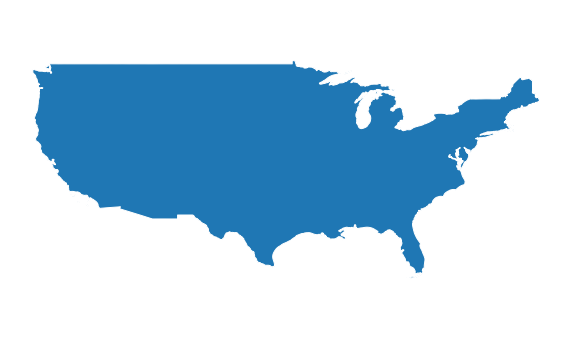

In [7]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
cont_usa.reset_index().plot(column="LSAD",
                           ax=ax)

ax.set_axis_off()
plt.axis("equal")
plt.show()

## Dissolve and aggregate data

In the example above, you dissolved the state level polygons to a region level. However, you duid not aggregate or summarise the attributes associated with each polygon. Next, you will learn how to aggregate quantitative values in your attribute table when you perform a dissolve. Add

aggfunc = "fun_here"

to your dissolve call, you can choose a suite of different summary functions including:
- first
- last
- mean
- max

Below the data are aggregated by the "sum" method. This means that the values for ALAND are added up for all of the states in a region. That summary sum value will be returned in the new dataframe.

In [8]:
# Select the columns that you wish to retain in the data
state_boundary = state_boundary_us[["region", "geometry", "ALAND", "AWATER"]]

# Then summarise the quantitative columns by "sum"
regions_agg = state_boundary.dissolve(by="region", aggfunc="sum")
regions_agg

,geometry,ALAND,AWATER
region,,,
Midwest,"MULTIPOLYGON Z (((-87.80048 42.49192 0.00000, ...",1943869253244,184383393833
Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",869066138232,108922434345
Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",1364632039655,103876652998
Southwest,"POLYGON Z ((-94.48587 33.63787 0.00000, -94.41...",1462631530997,24217682268
West,"MULTIPOLYGON Z (((-104.05325 41.00141 0.00000,...",2432336444730,57568049509


In [9]:
# Convert area units from square meters to hectares (divide by 10,000)
regions_agg["land_ha"] = regions_agg["ALAND"]/10000
regions_agg["water_ha"] = regions_agg["AWATER"]/10000
regions_agg

,geometry,ALAND,AWATER,land_ha,water_ha
region,,,,,
Midwest,"MULTIPOLYGON Z (((-87.80048 42.49192 0.00000, ...",1943869253244,184383393833,1.943869e+08,1.843834e+07
Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",869066138232,108922434345,8.690661e+07,1.089224e+07
Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",1364632039655,103876652998,1.364632e+08,1.038767e+07
Southwest,"POLYGON Z ((-94.48587 33.63787 0.00000, -94.41...",1462631530997,24217682268,1.462632e+08,2.421768e+06
West,"MULTIPOLYGON Z (((-104.05325 41.00141 0.00000,...",2432336444730,57568049509,2.432336e+08,5.756805e+06


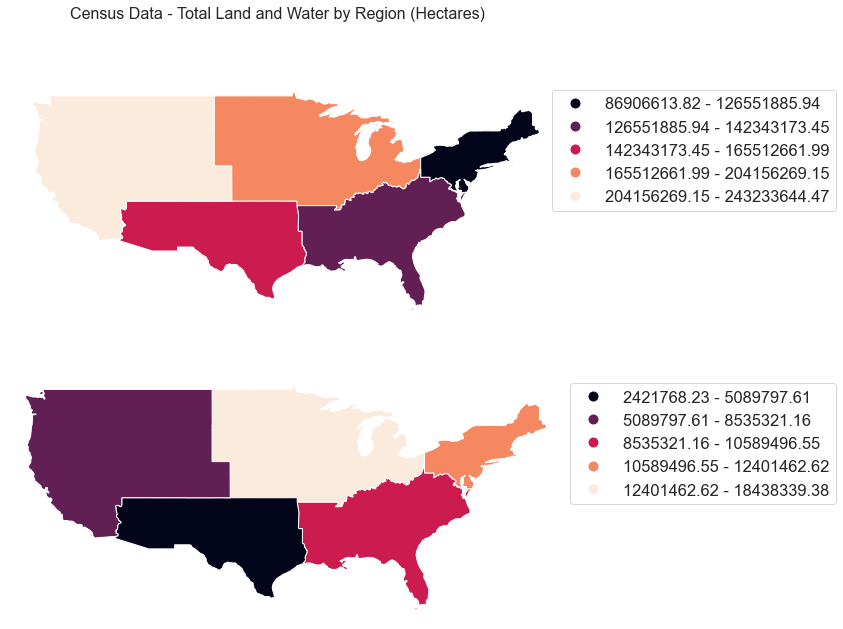

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

regions_agg.plot(column="land_ha",
                legend=True,
                scheme="quantiles",
                ax=ax1)

regions_agg.plot(column="water_ha",
                scheme="quantiles",
                legend=True,
                ax=ax2)

plt.suptitle("Census Data - Total Land and Water by Region (Hectares)", fontsize=16)
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1.5, 1))

leg = ax2.get_legend()
leg.set_bbox_to_anchor((1.5, 1))
ax1.set_axis_off()
ax2.set_axis_off()

plt.axis("equal")
plt.show()